# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [6]:
import gym
import numpy as np

In [7]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [8]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [9]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [10]:
batch[0], batch[0][1].shape

([0,
  array([ 0.02211954, -0.1711269 ,  0.03455936,  0.27322888]),
  1.0,
  False,
  {}],
 (4,))

In [11]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [12]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5724473502969136 -2.750646069543256


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [16]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, targetQs

In [17]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        alogits = tf.layers.dense(inputs=nl2, units=action_size)        
        qlogits = tf.layers.dense(inputs=alogits, units=1, trainable=False)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return alogits, qlogits

In [23]:
def model_loss(actions, states, targetQs, # model inputs
               action_size, hidden_size): # model init for Qs
        
    actions_logits, value_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    # Policy gradient/optimization (policy learning)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    
    # Value gradients/optimization (Q-learning)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, value_logits, loss

In [24]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [25]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.value_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [26]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [29]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [30]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [31]:
env.reset()

array([ 0.01879697,  0.02010033, -0.0260282 , -0.04725856])

In [32]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [33]:
state, reward, action

(array([-0.14441889, -1.36386987,  0.11488285,  1.87557869]), 1.0, 0)

In [34]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state, reward])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        
        # Calculating targetQs
        value_logits = sess.run(model.value_logits, feed_dict={model.states: states})            
        rewarded_value_logits = np.multiply(value_logits, np.reshape(rewards, [-1, 1]))
        Qs = np.max(value_logits, axis=1)

        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states,
                                                                 model.targetQs: Qs})
        
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 26 Batch loss: 1.379005671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 56 Batch loss: 1.369302511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 46 Batch loss: 1.366110563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 54 Batch loss: 1.353893757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4 Total reward: 75 Batch loss: 1.331334591
--------------------

-------------------------------------------------------------------------------
Episode: 41 Total reward: 28 Batch loss: 1.085701823
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 42 Total reward: 42 Batch loss: 1.134431839
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 25 Batch loss: 1.035828114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 29 Batch loss: 1.058565736
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 45 Total reward: 38 Batch loss: 1.129741669
---------------

-------------------------------------------------------------------------------
Episode: 81 Total reward: 68 Batch loss: 1.005717516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 82 Total reward: 25 Batch loss: 0.811783254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 83 Total reward: 50 Batch loss: 0.772271931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 84 Total reward: 75 Batch loss: 0.875554085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 85 Total reward: 26 Batch loss: 0.912710905
---------------

-------------------------------------------------------------------------------
Episode: 120 Total reward: 25 Batch loss: 0.650145233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 36 Batch loss: 0.660622835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 24 Batch loss: 0.717281938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 25 Batch loss: 0.832019687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 30 Batch loss: 1.005917430
----------

-------------------------------------------------------------------------------
Episode: 159 Total reward: 79 Batch loss: 0.735118985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 160 Total reward: 25 Batch loss: 0.566921413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 161 Total reward: 28 Batch loss: 0.620140433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 28 Batch loss: 0.667562127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 26 Batch loss: 0.706539512
----------

-------------------------------------------------------------------------------
Episode: 200 Total reward: 24 Batch loss: 0.577232540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 26 Batch loss: 0.564196646
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 34 Batch loss: 0.530857682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 203 Total reward: 24 Batch loss: 0.594144344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 28 Batch loss: 0.813913047
----------

-------------------------------------------------------------------------------
Episode: 241 Total reward: 41 Batch loss: 0.501124978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 27 Batch loss: 0.448525399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 54 Batch loss: 0.800958991
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 40 Batch loss: 0.515222490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 26 Batch loss: 0.568463743
----------

-------------------------------------------------------------------------------
Episode: 282 Total reward: 22 Batch loss: 0.748724163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 24 Batch loss: 0.540984511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 284 Total reward: 28 Batch loss: 0.561231971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 285 Total reward: 49 Batch loss: 0.731124520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 286 Total reward: 26 Batch loss: 0.659667253
----------

-------------------------------------------------------------------------------
Episode: 321 Total reward: 67 Batch loss: 0.724523604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 322 Total reward: 38 Batch loss: 0.527069747
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 26 Batch loss: 0.663916528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 33 Batch loss: 0.583175480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 46 Batch loss: 0.695265174
----------

-------------------------------------------------------------------------------
Episode: 362 Total reward: 60 Batch loss: 0.457436949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 84 Batch loss: 0.693536818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 34 Batch loss: 0.514969230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 68 Batch loss: 0.448432565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 30 Batch loss: 0.619043112
----------

-------------------------------------------------------------------------------
Episode: 401 Total reward: 27 Batch loss: 0.436570138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 22 Batch loss: 0.619645476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 30 Batch loss: 0.515938044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 70 Batch loss: 0.741141558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 405 Total reward: 26 Batch loss: 0.654874682
----------

-------------------------------------------------------------------------------
Episode: 443 Total reward: 61 Batch loss: 0.425322175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 56 Batch loss: 0.450409591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 38 Batch loss: 0.507119894
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 25 Batch loss: 0.440312862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 447 Total reward: 27 Batch loss: 0.511464000
----------

-------------------------------------------------------------------------------
Episode: 485 Total reward: 53 Batch loss: 0.430839360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 53 Batch loss: 0.494868279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 32 Batch loss: 0.492153734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 74 Batch loss: 0.711043954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 489 Total reward: 50 Batch loss: 0.464530915
----------

-------------------------------------------------------------------------------
Episode: 527 Total reward: 120 Batch loss: 0.614583015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 528 Total reward: 22 Batch loss: 0.540314019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 23 Batch loss: 0.438584119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 530 Total reward: 28 Batch loss: 0.493198663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 23 Batch loss: 1.019247770
---------

-------------------------------------------------------------------------------
Episode: 569 Total reward: 25 Batch loss: 0.540098011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 41 Batch loss: 0.625652492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 571 Total reward: 43 Batch loss: 0.585739315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 572 Total reward: 30 Batch loss: 0.549133420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 573 Total reward: 37 Batch loss: 0.656290114
----------

Episode: 610 Total reward: 25 Batch loss: 0.821813643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 611 Total reward: 32 Batch loss: 0.662282169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 612 Total reward: 57 Batch loss: 0.545944989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 34 Batch loss: 0.488764286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 30 Batch loss: 0.546671748
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 651 Total reward: 97 Batch loss: 0.607828379
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 24 Batch loss: 0.534104347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 56 Batch loss: 0.712836742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 20 Batch loss: 0.594399750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 655 Total reward: 25 Batch loss: 0.695317328
----------

-------------------------------------------------------------------------------
Episode: 693 Total reward: 75 Batch loss: 0.500218749
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 37 Batch loss: 0.546837986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 43 Batch loss: 0.526229799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 696 Total reward: 24 Batch loss: 0.562654734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 697 Total reward: 61 Batch loss: 0.511670589
----------

-------------------------------------------------------------------------------
Episode: 736 Total reward: 23 Batch loss: 0.684847057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 737 Total reward: 27 Batch loss: 0.594958901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 738 Total reward: 46 Batch loss: 0.479335934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 19 Batch loss: 0.658328891
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 86 Batch loss: 0.669943750
----------

-------------------------------------------------------------------------------
Episode: 776 Total reward: 24 Batch loss: 0.725666165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 777 Total reward: 20 Batch loss: 0.793993473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 778 Total reward: 10 Batch loss: 0.857484281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 779 Total reward: 16 Batch loss: 0.793188035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 14 Batch loss: 0.784274757
----------

-------------------------------------------------------------------------------
Episode: 816 Total reward: 62 Batch loss: 0.663116574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 29 Batch loss: 0.645782828
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 25 Batch loss: 0.599703252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 18 Batch loss: 0.629900217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 25 Batch loss: 0.607939959
----------

-------------------------------------------------------------------------------
Episode: 856 Total reward: 38 Batch loss: 0.496289611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 69 Batch loss: 0.741714358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 18 Batch loss: 0.629141390
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 74 Batch loss: 0.698904037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 50 Batch loss: 0.472675562
----------

-------------------------------------------------------------------------------
Episode: 896 Total reward: 23 Batch loss: 0.554192662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 19 Batch loss: 0.574432552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 898 Total reward: 29 Batch loss: 0.499686509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 36 Batch loss: 0.520163119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 34 Batch loss: 0.485725969
----------

-------------------------------------------------------------------------------
Episode: 937 Total reward: 48 Batch loss: 0.449332118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 60 Batch loss: 0.625538647
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 36 Batch loss: 0.493349552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 940 Total reward: 26 Batch loss: 0.518528759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 25 Batch loss: 0.549056411
----------

-------------------------------------------------------------------------------
Episode: 977 Total reward: 25 Batch loss: 0.552637279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 67 Batch loss: 0.861751556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 979 Total reward: 41 Batch loss: 0.461781710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 980 Total reward: 52 Batch loss: 0.684965312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 62 Batch loss: 0.785097659
----------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

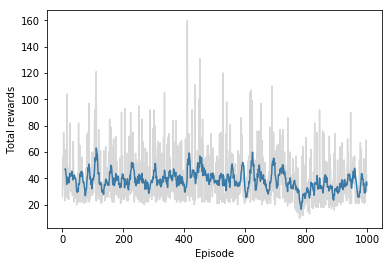

In [36]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

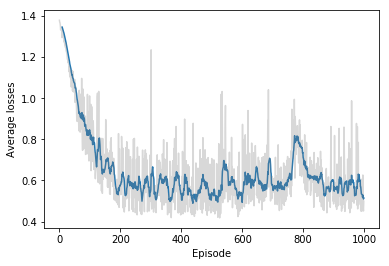

In [37]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [5]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        env.render()
        
        # number of env/rob steps
        for each_step in range(10000000000000000000):
            
            # Calculating action using model            
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


NameError: name 'saver' is not defined

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.